In [1]:
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import metrics
from utils import *
from model2 import *


Using TensorFlow backend.
c:\Users\him19\anaconda3\envs\7409\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [29]:






#data1 = pd.read_csv('./^SPX2.csv')
data1 = pd.read_csv('./^SPX.csv')
data1.index = pd.to_datetime(data1['Date'], format='%Y-%m-%d') 
#data1 = data1.drop(['ts_code', 'trade_date', 'turnover_rate', 'volume_ratio', 'pb', 'total_share', 'float_share', 'free_share'], axis=1)
data1 = data1.loc[:, ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]
data_all = data1
residuals = pd.read_csv('./ARIMA_residuals(svx).csv')
residuals.index = pd.to_datetime(residuals['Date'])
residuals.pop('Date')
data1 = pd.merge(data1, residuals, on='Date')
#data = data1.iloc[21098:23878, :] 
#data2 = data1.iloc[23878:23998, :] 
#train_data = data1.iloc[1:2780, :] 
#test_data = data1.iloc[2780:, :] 
train_data = data1.iloc[18000:21439, :] 
test_data = data1.iloc[21439:, :] 

In [30]:
TIME_STEPS = 20

#train_data=np.array(train_data)
train_data, normalize = NormalizeMult(train_data)
#print('#', normalize)
pollution_data = train_data[:, 3].reshape(len(train_data), 1)

train_X, _ = create_dataset(train_data, TIME_STEPS)
_, train_Y = create_dataset(np.array(pollution_data), TIME_STEPS)

print(train_X.shape, train_Y.shape)


(7, 2)
(3418, 20, 7) (3418, 1)


In [31]:
m = attention_model(INPUT_DIMS=7)
m.summary() 
adam = Adam(learning_rate=0.01)
m.compile(optimizer=adam, loss='mse') 
history = m.fit([train_X], train_Y, epochs=50, batch_size=32, validation_split=0.1)
m.save("./stock_model.h5")
#np.save("stock_normalize.npy", normalize)

wwwwwww
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 20, 7)             0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 20, 64)            512       
_________________________________________________________________
dropout_3 (Dropout)          (None, 20, 64)            0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 20, 128)           66048     
_________________________________________________________________
dropout_4 (Dropout)          (None, 20, 128)           0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 2560)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)             

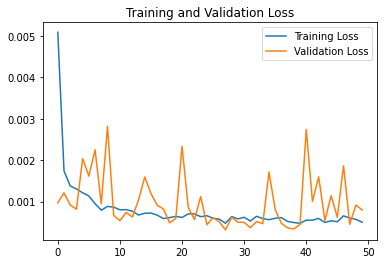

In [32]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [33]:
test_data, normalize = NormalizeMult(test_data)
print('#', normalize[0,0])
pollution_data = test_data[:, 3].reshape(len(test_data), 1)

test_X, _ = create_dataset(test_data, TIME_STEPS)
_, test_Y = create_dataset(pollution_data, TIME_STEPS)

print(test_X.shape, test_Y.shape)

(7, 2)
# 1577.52002
(2537, 20, 7) (2537, 1)


In [44]:
y_test=test_Y

In [45]:
y_hat =  m.predict(test_X)

In [46]:
y_test=FNormalizeMult(y_test,normalize[3])
y_hat=FNormalizeMult(y_hat,normalize[3])

In [40]:
y_hat[0]

array([1810.14468393])

In [6]:
class Config:
    def __init__(self):
        self.dimname = 'Close'

config = Config()
name = config.dimname
# normalize = np.load("normalize.npy")
#y_hat, y_test = PredictWithData(data2, data_yuan, name,m, 'stock_model.h5',7)


In [10]:
y_hat, y_test = PredictWithData(test_data, data_all , name,m, 'stock_model.h5',7)

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', '0'], dtype='object')
testX Y shape is: (2537, 20, 7) (2537, 1)


MSE: 8656.41531
RMSE: 93.03986
MAE: 77.72220
R2: 0.98888


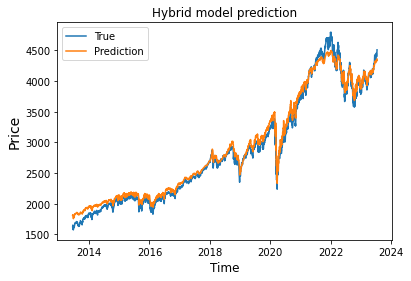

In [47]:
y_hat = np.array(y_hat, dtype='float64')
y_test = np.array(y_test, dtype='float64')
evaluation_metric(y_test,y_hat)
time = pd.Series(data1.index[21438:])
plt.plot(time[22:], y_test, label='True')
plt.plot(time[22:], y_hat, label='Prediction')
plt.title('Hybrid model prediction')
plt.xlabel('Time', fontsize=12, verticalalignment='top')
plt.ylabel('Price', fontsize=14, horizontalalignment='center')
plt.legend()
plt.show()

In [60]:
len(y_test)

2537

In [61]:
len(test_data[:,3].tolist()[21:])

2537

In [62]:
predictions = {
    'trade_date': test_data[:,3].tolist()[21:],
    'close': y_test.tolist(),
    'predict':y_hat.tolist()
}
predictions1 = pd.DataFrame(predictions)
predictions1 = predictions1.set_index(['trade_date'], drop=True)
predictions1.to_csv('./predict3.csv')